<a href="https://colab.research.google.com/github/arnauddyevre/ec539_assignment1/blob/master/code/EC539_assignment1_Dyevre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EC539 - Assignment 1
Reproduction of the numerical results in *N. Kiyotaki & J. Moore* "Credit Cycles" (1997)

Arnaud Dyevre

*Friday, January 17*

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arnauddyevre/ec539_assignment1/blob/master/EC539_assignment1_Dyevre.ipynb)

This Notebook reproduces Figure 3 of "Credit Cycles" (1997), by Kiyotaki and Moore. It uses a shooting algorithm to find the Initial Value Condition that reproduces the cyclicality of the full non-linear model, while converging to the steady state in the long run.


### Content

- [1. Model equations](#1.-Model-equations)
- [2. Numerical solution](#2.-Numerical-solutions)
- [3. Parameter values](#3.-Parameter-values)
- [4. Steady state values](#4.-Steady-state-values)

### 1. Model equations

*(1) Land market equilibrium condition*
$$q_{t+1}= R(q_{t} - u\left(K_{t}\right))$$

*(2) Law of motion of the farmers' aggregate landholding*
$$\begin{equation}
K_{t}=(1-\pi) \lambda K_{t-1} +\frac{\pi}{\phi + q_t - \frac{1}{R} q_{t+1}}\left[\left(a+q_{t}+\lambda \phi\right) K_{t-1}-R B_{t-1}\right]
\end{equation}$$

*(3) Law of motion of the farmers' aggregate debt*
$$B_{t}=R B_{t-1}+q_{t}\left(K_{t}-K_{t-1}\right)+\phi\left(K_{t}-\lambda K_{t-1}\right)-a K_{t-1}$$

Where:

- $ q_t = $ price of land 
- $K_t=$ landholding of farmers
- $ B_t = $ aggregate debt of farmers
- $R_t = R = $ constant rate of interest
- $u(.) =$ downpayment required for the purchase of $K_t$ units or land (also opportunity cost of holding land)
- $a = $ constant proportional to the share of tradeable fruit (also "productivity" in the model)
- $\lambda =$ fraction of trees surviving after one period
- $\pi = $ probability that a new opportunity to plant tree arises
- $\phi = $ amount of trees created with one fruit  

### 2. Numerical solution

I solve model (1)-(2)-(3) numerically, by forward shooting. The steps are:
  - 1. Finding the steady state values $(q^*, K^*, B^*)$.
  - 2. Defining a one-dimensional grid of initial values $\mathbf{q}_1$ in the neighbourhood of $1.0037 \times q^*$ as the paper suggests. I use a grid of $1,000$ initial guesses in $[q^*(1.0037-0.0005), q^*(1.0037+0.0005)]$ here, as the paper indicates that the initial increase in $q_t$ is of $0.37\%$.
  - 3. Using a numerical optimisation routine to solve the non-linear sets of equations $\begin{pmatrix} q_{t+1} \\ K_t \\ B_t \end{pmatrix} = f\begin{pmatrix} q_{t} \\ K_{t-1} \\ B_{t-1} \end{pmatrix}$, $\forall t$. I know  $\begin{pmatrix} q_0 \\ K_0 \\ B_0 \end{pmatrix} = f\begin{pmatrix} q^* \\ K^* \\ B^* \end{pmatrix}$ and I guess $q_1$.
  - 4. Finding $q_1^* = \underset{q_1}{\arg \min} |q^* - q_1 | $, and using this $q_1^*$ to draw the impulse response functions of $B_t/B^*$, $K_t/K^*$ and $q_t/q^*$
 

### 3. Parameter values

The following parameter values come from the paper (p. 237)

$R = 1.01 \\
\lambda = 0.975\\
\eta = 0.10 \\
a = 1\\
\Delta a = 0.01\\
\pi = 0.1\\
\phi = 20\\
$

I use the functional form $u(K) = K - \nu$ where $\nu$ is set to make $\eta$, the elasticity of the residual supply of land to farmers, equal to 10 percent in the steady state. So $\nu$ is given by:

$$ \dfrac{1}{\eta} = \left . \dfrac{\mathrm{d} \log(K - \nu)}{\mathrm{d} log(K)} \right|_{K = K^*} = \left.\dfrac{\mathrm{d} (K - \nu)}{\mathrm{d}K}\right|_{K=K^*} \dfrac{K^*}{K^*-\nu} = \dfrac{K^*}{K^*-\nu} $$

So $\nu = K^*(1 - \eta)$ and $K^* = \frac{R - 1}{R} \dfrac{q^*}{\eta}$

#### 4. Steady state values

In steady state:

$$\begin{align} 
q^{*} & =\frac{R}{R-1}  \frac{\pi a-(1-\lambda)(1-R+\pi R) \phi}{\lambda \pi+(1-\lambda)(1-R+\pi R)} \\
B^{*} & =\frac{1}{R-1}(a-\phi+\lambda \phi) K^{*}\\
K^* & = \frac{R - 1}{R} \dfrac{q^*}{\eta}
\end{align}$$

The system is initialised with these values, and should return to them in the long run.

In [0]:
#Necessary modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels as sm
import scipy.optimize as opt

In [2]:
#Timeline
periods = 100+1

#Guesses
trials = 1000

#Parameter values
R = 1.01
λ = 0.975
η = 0.10
a = 1.0
Δa = 0.01
π = 0.1
ϕ = 20.0
c = 1.0

#Finding the steady state values
q_star = (R/(R-1))*(π*a - (1-λ)*(1 - R + π*R)*ϕ) / (λ*π + (1-λ)*(1 - R + π*R))
ν = ((R -1)/R)*(q_star/η)
K_star = ((R-1)/R)*q_star + ν
B_star = (1/(R-1))*(a - ϕ + λ*ϕ)*K_star

q_star, K_star, B_star, ν

(55.1691305437233, 6.008519168128284, 300.42595840641394, 5.462290152843895)

In [0]:
#Initialising the initial values and productivity shock
Δt = np.zeros(periods)
Δt[1] = Δa

In [0]:
#Generating guess values for q_1
q_vec = np.linspace(q_star*(1.0037-0.0005), q_star*(1.0037+0.0005), trials)
q_vecSS = np.linspace(q_star, q_star, trials)
q_mat = np.zeros((trials, periods))
q_mat[:,1] = q_vec
q_mat[:,0] = q_vecSS

#Initialising the matrices of B's and K's
B_mat = np.zeros((trials, periods))
K_mat = np.zeros((trials, periods))
B_vec = np.linspace(B_star, B_star, trials)
K_vec = np.linspace(K_star, K_star, trials)
B_mat[:,0] = B_vec
K_mat[:,0] = K_vec

In [0]:
#Solving the model each period, for all guesses of q_1
for s in range(0, trials):
  for t in range(1, periods-1):
    def f(variables):
      (q_tplus1, K_t, B_t) = variables
      first_eq = -(q_tplus1 - R*q_mat[s, t] + R*(K_t - ν))
      second_eq = -(K_t - (1-π)*λ*K_mat[s, t-1] - (π/(ϕ + q_mat[s, t] - (q_tplus1/R)))*( (a + Δt[t] +q_mat[s, t] + λ*ϕ)*K_mat[s, t-1] - R*B_mat[s, t-1]))
      third_eq = -(B_t - R*B_mat[s, t-1] - q_mat[s, t]*(K_t - K_mat[s, t-1]) - ϕ*(K_t - λ*K_mat[s, t-1]) + (a+Δt[t])*K_mat[s, t-1]) 
      return [first_eq, second_eq, third_eq]

    solution = opt.fsolve(f, (q_star, K_star, B_star))
    q_mat[s, t+1], K_mat[s, t], B_mat[s, t] = solution     

Selecting the initial value of land price $q_1$ for which the long term price $q_T$ is closest to $q^*$.

In [6]:
#Defining a new vector of absolute distances to the steady state vale q*
q_vec_abs = np.zeros(trials)
for i in range(0, trials):
  q_vec_abs[i] = abs(1 - q_mat[i, -1]/q_star)

#Smallest absolute deviation
index = np.argwhere(q_vec_abs == np.min(q_vec_abs))[0, 0]
index, q_mat[index, -1], q_vec[index], q_vec_abs[index]

(827, 55.16912907390393, 55.39134230296437, 2.6642061445869558e-08)

Graphing the impulse functions of the selected initial values:

(0.998, 1.006)

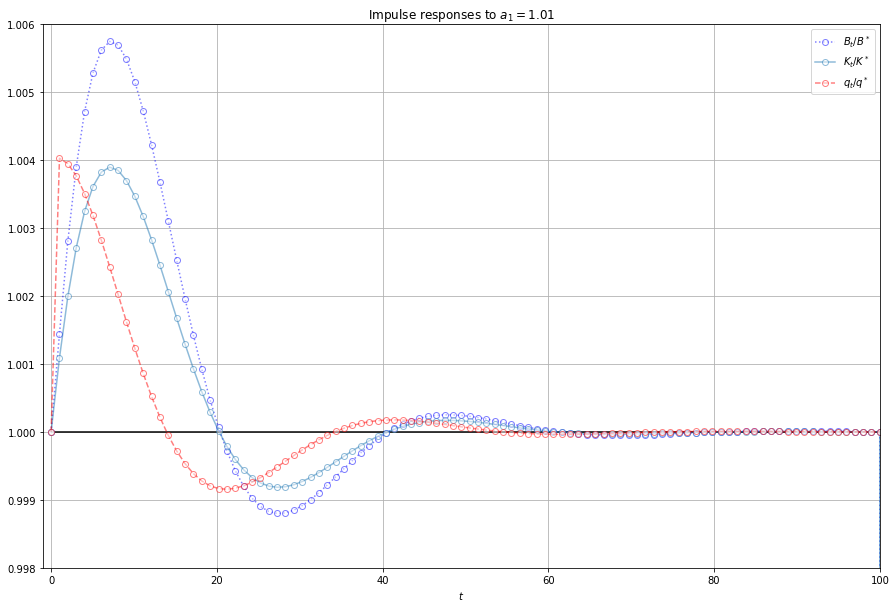

In [7]:
time = np.linspace(0, periods, periods)                                    

B_graph = B_mat[index, :]/B_star
K_graph = K_mat[index, :]/K_star
q_graph = q_mat[index, :]/q_star

plt.figure(1, figsize=(15,10))
plt.title("Impulse responses to $a_1 = 1.01$")
plt.plot(time, B_graph, 'b:', alpha=0.5, marker='o', fillstyle='full', markerfacecolor='white', label='$B_t/B^*$')
plt.plot(time, K_graph, alpha=0.5, marker='o', fillstyle='full', markerfacecolor='white', label='$K_t/K^*$')
plt.plot(time, q_graph, 'r--', alpha=0.5, marker='o', fillstyle='full', markerfacecolor='white', label='$q_t/q^*$')
plt.xlabel("$t$" "")
plt.legend()
plt.grid()
plt.hlines(1, 0, 100)
plt.xlim(-1, 100)
plt.ylim(0.998, 1.006)

In [0]:
plt.savefig('H:\KM_Fig3.pdf')
plt.close(1)